# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [3]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-11-13 09:00:00+09:00,51013.148438,51196.910156,50958.210938,51141.808594,0,0.0,0.0
2025-11-13 09:15:00+09:00,51119.199219,51166.039062,51014.949219,51020.371094,0,0.0,0.0
2025-11-13 09:30:00+09:00,51021.011719,51107.871094,50954.269531,51100.851562,0,0.0,0.0
2025-11-13 09:45:00+09:00,51096.171875,51096.171875,50980.261719,51037.230469,0,0.0,0.0
2025-11-13 10:00:00+09:00,51041.589844,51326.089844,51012.160156,51269.511719,0,0.0,0.0
2025-11-13 10:15:00+09:00,51271.769531,51338.890625,51225.769531,51225.769531,0,0.0,0.0
2025-11-13 10:30:00+09:00,51231.878906,51295.878906,51231.878906,51232.820312,0,0.0,0.0
2025-11-13 10:45:00+09:00,51237.640625,51256.351562,51168.218750,51173.851562,0,0.0,0.0


## 前日終値の取得

In [4]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-11-06 00:00:00+09:00    50883.679688
2025-11-07 00:00:00+09:00    50276.371094
2025-11-10 00:00:00+09:00    50911.761719
2025-11-11 00:00:00+09:00    50842.929688
2025-11-13 00:00:00+09:00    51173.851562
Name: Close, dtype: float64


Date
2025-11-11 00:00:00+09:00    50842.929688
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [5]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

+170.22


## ローソク足チャート（小さいサイズ）

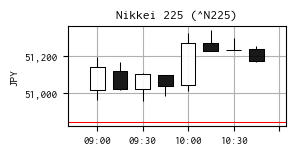

In [6]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.6))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [7]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [8]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-11-12 09:00:00+09:00,154.078003,154.162003,154.042007,154.059006,0,0.0,0.0
2025-11-12 09:15:00+09:00,154.063995,154.195007,154.050995,154.173996,0,0.0,0.0
2025-11-12 09:30:00+09:00,154.175003,154.257004,154.169998,154.242996,0,0.0,0.0
2025-11-12 09:45:00+09:00,154.242996,154.302002,154.192001,154.292999,0,0.0,0.0
2025-11-12 10:00:00+09:00,154.292999,154.352005,154.255997,154.317001,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-11-13 10:00:00+09:00,154.936005,154.992004,154.919006,154.972000,0,0.0,0.0
2025-11-13 10:15:00+09:00,154.972000,155.014999,154.878006,154.908005,0,0.0,0.0
2025-11-13 10:30:00+09:00,154.908005,154.942993,154.882004,154.893005,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [9]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-11-13 09:00:00+09:00,329.465686,330.652501,329.110875,330.296630
2025-11-13 09:15:00+09:00,330.265793,330.568411,329.592265,329.627294
2025-11-13 09:30:00+09:00,329.524979,330.085970,329.093917,330.040633
2025-11-13 09:45:00+09:00,329.776119,329.776119,329.028032,329.395710
2025-11-13 10:00:00+09:00,329.360077,331.195892,329.170173,330.830806
2025-11-13 10:15:00+09:00,330.982054,331.415350,330.685103,330.685103
2025-11-13 10:30:00+09:00,330.756568,331.169757,330.756568,330.762646
2025-11-13 10:45:00+09:00,331.137983,331.258908,330.689324,330.725728


### 前日の終値のドル円レートから、前日の終値のドル換算

In [10]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-11-12 15:15:00+09:00


np.float64(154.65499877929688)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

前日終値（ドル換算） 328.75063909221774


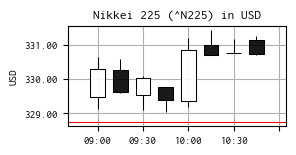

In [11]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.6))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()